# Flightpath characterization
In this notebook we look at the characterization of the flight path. Up until now we've just flown in a circle, parameterized by radius and speed. That's pretty boring for the optimization, so let's look at something more interesting.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse as sparse

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationDAE import NavigationDAE as Navigation

from Optimization.Optimization import Optimization as Optimizer
from Constraints import Constraints
from Flight import Flight

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.9, 0.9], [0.8, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 500

meshDim = 20  # discretization parameter (1D) for FOM
polyDim = 3

n_test = 100 # resolution for 1D plots

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 1, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 0)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(default_mode="D")

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 2.811095714569092 s


In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

## Path characterization

In [5]:
initial = np.array([0.7, 0.3, 2])
velocity = np.array([0.8]*n_steps)
angular_velocity = np.array([1]*n_steps)

alpha = np.hstack([initial, velocity, angular_velocity])

(-0.05, 1.05)

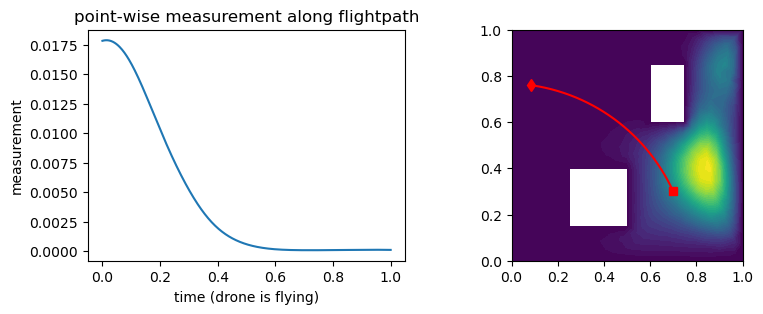

In [6]:
# compute flight
flight = drone.plan_flight(alpha=alpha, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t, valid_positions = flight.get_positions()  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

It is very, very important that we are not just treating missing measurements as zero. Remember that we are using a correlated noise model. Substituting missing measurements with zero is not the same as taking them out.

In [7]:
# compute posterior
posterior_ref = inversion.compute_posterior(alpha=alpha)
util_ref = [utility.eval_utility(posterior_ref, mode="A"), utility.eval_utility(posterior_ref, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior_ref, mode="E"))

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


A-OED: 1.9504708443119494
D-OED: 0.950470853342699
E-OED: 0.9999998176673367


## Optimization

In [8]:
constraints = Constraints(navigation = navigation)

#navigation.set_control_bounds([0.6, 0.2, -1, 0.6, -1], [0.8, 0.4, 3, 0.9, 2])
#navigation.set_control_bounds([0.7, 0.3, 2, 0.8, 2], [0.7, 0.3, 2, 0.8, 2])
navigation.set_control_bounds([0.7, 0.3, 0, 0.8, 0], [0.7, 0.3, 2*np.pi, 0.8, 5])

lower = np.hstack([np.zeros((2*n_steps,)), -np.infty * np.ones((n_steps,)), navigation.lower])
constraints.set_bounds(lower, bool_lower = True)

upper = np.hstack([np.ones((2*n_steps,)), np.infty * np.ones((n_steps,)), navigation.upper])
constraints.set_bounds(upper, bool_lower = False)

In [9]:
problem_obj = Optimizer(utility=utility, inverse_problem=inversion, constraints=constraints)

problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-4)
#problem_obj.add_option("max_iter", 100)

In [10]:
x0 = np.hstack([flight.flightpath[:, i] for i in range(flight.flightpath.shape[1])])
x0 = np.hstack([x0, alpha])

In [11]:
print("Sanity check (upper): ", (x0 <= problem_obj.upper_bounds).all())
print("Sanity check (lower): ", (x0 >= problem_obj.lower_bounds).all())

Sanity check (upper):  True
Sanity check (lower):  True


In [ ]:
solution, info = problem_obj.solve(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4495
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1500
Total number of inequality c

  78  9.4994852e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  79  9.4994169e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.4993484e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  81  9.4992800e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  82  9.4992116e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  83  9.4991431e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  84  9.4990746e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  85  9.4990060e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  86  9.4989375e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  87  9.4988689e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  88  9.4988003e-01 1.09e-11 1.22e-04 -11.0 1.22e-04    -  1.00e+00 1.00e+00h  1
  89  9.4987316e-01 1.09e-11

 171  9.4930152e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 172  9.4929444e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 173  9.4928735e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 174  9.4928027e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 175  9.4927318e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 176  9.4926609e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 177  9.4925899e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 178  9.4925190e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 179  9.4924480e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  9.4923770e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 181  9.4923059e-01 1.13e-11 1.24e-04 -11.0 1.24e-04    -  1.00e+00 1.00e+00h  1
 182  9.4922348e-01 1.13e-11

 264  9.4863136e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 265  9.4862403e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 266  9.4861669e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 267  9.4860934e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 268  9.4860200e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 269  9.4859465e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  9.4858730e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 271  9.4857995e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 272  9.4857259e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 273  9.4856523e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 274  9.4855787e-01 1.18e-11 1.26e-04 -11.0 1.26e-04    -  1.00e+00 1.00e+00h  1
 275  9.4855050e-01 1.18e-11

In [ ]:
(flightpath_1d_opt, controls_opt) = problem_obj.var_splitter(solution)

flight_controlled = Flight(navigation=navigation, alpha = controls_opt)
flight_by_path = Flight(navigation=navigation, flightpath = flightpath_1d_opt)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])

axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")


axs[1].plot(flight_by_path.flightpath[:, 0], flight_by_path.flightpath[:, 1], color="g")
axs[1].plot(flight_controlled.flightpath[:, 0], flight_controlled.flightpath[:, 1], color="y", linestyle = "--")

**Welcome back!**
I started to write the Navigation for the DAE system, and took everything apart in the process :(
The problem is that the DAE system has the heading theta as additional state, and I've treated it as another position-type variable, since it's not a direct control. It's really more of an auxilliary variable. It's just throwing all of the different counters off.

Next steps:
- bring back to a form where MultiSegment works?
- implement the missing constraints (houses)
- implement regularization

## The End.

In [ ]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))